In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

In [5]:
!pip install statsmodels
!pip install pmdarima

In [6]:
# Data from 04/15/14 - 04/11/24
data = pd.read_csv('TSLA.csv') #reading stock prices

In [7]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-15,13.272667,13.286000,12.288000,12.927333,12.927333,204889500
1,2014-04-16,13.133333,13.332667,12.721333,13.274000,13.274000,108033000
2,2014-04-17,13.307333,13.486000,12.938667,13.208000,13.208000,88902000
3,2014-04-21,13.138667,13.746667,12.933333,13.625333,13.625333,78873000
4,2014-04-22,13.757333,14.622000,13.667333,14.576000,14.576000,147070500


In [8]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,99.110539,101.271058,96.781269,99.080561,99.080561,1.121508e+08
std,108.956969,111.368033,106.286547,108.856288,108.856288,7.431763e+07
min,9.488000,10.331333,9.403333,9.578000,9.578000,1.062000e+07
25%,16.248000,16.481000,15.971334,16.222334,16.222334,6.645840e+07
50%,22.660667,23.040001,22.266666,22.639999,22.639999,9.286500e+07
75%,203.660004,208.220001,198.510002,203.351669,203.351669,1.300028e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [9]:
# Check for missing values
print(data.isnull().sum())

# Check for duplicates
print(data.duplicated().sum())

# Check data types
print(data.dtypes)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
0
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


<Axes: >

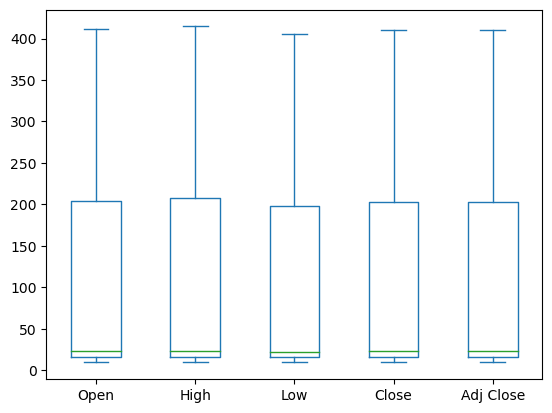

In [10]:
# Box plot to visually check for outliers
data[['Open','High','Low','Close','Adj Close']].plot(kind='box') 

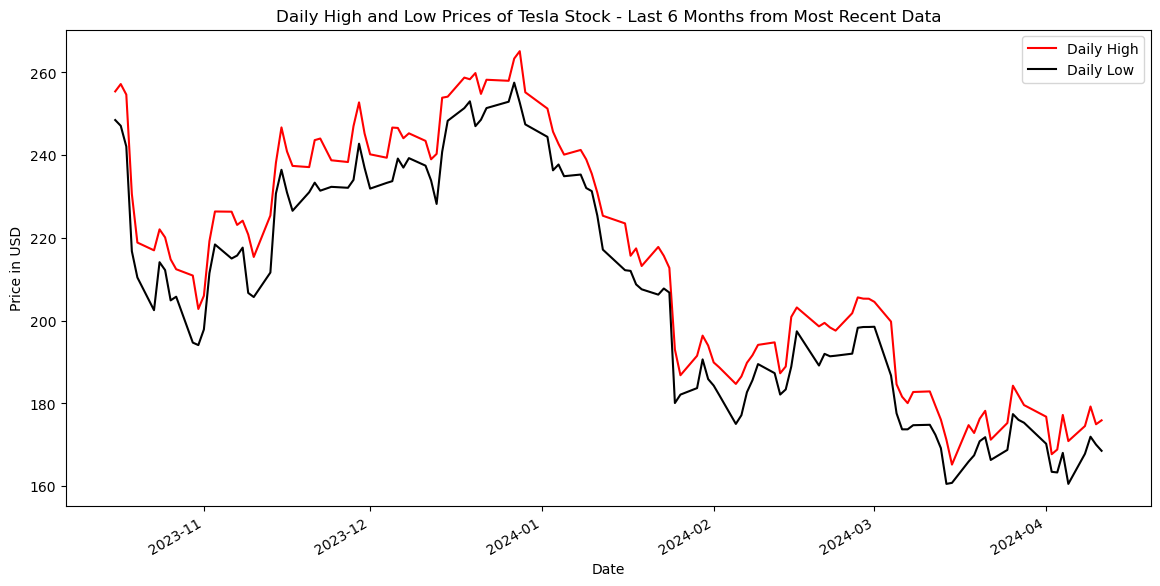

In [11]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Get the maximum date from the dataset which represents the most recent stock data
max_date = data['Date'].max()

six_months_prior = max_date - timedelta(days=180)

# Filter the data to get the range between three months prior and the maximum date
six_months_data_full = data[(data['Date'] >= six_months_prior) & (data['Date'] <= max_date)]

# Now let's plot the full six months of daily high and low prices
plt.figure(figsize=(14, 7))
plt.plot(six_months_data_full['Date'], six_months_data_full['High'], color='red', label='Daily High')
plt.plot(six_months_data_full['Date'], six_months_data_full['Low'], color='black', label='Daily Low')

# Formatting the plot
plt.title('Daily High and Low Prices of Tesla Stock - Last 6 Months from Most Recent Data')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(False)

# Improve date format on x-axis
plt.gcf().autofmt_xdate() # Rotation

# Show the plot
plt.show()

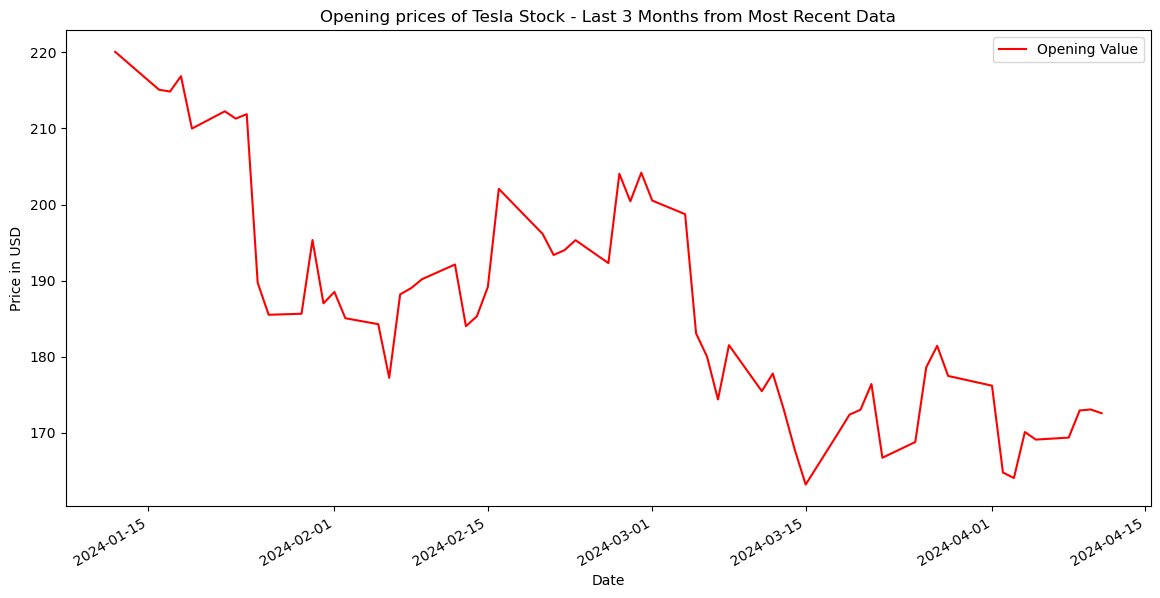

In [12]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Get the maximum date from the dataset which represents the most recent stock data
max_date = data['Date'].max()

# Calculate the date three months (approximately 90 days) before the maximum date
three_months_prior = max_date - timedelta(days=90)

# Filter the data to get the range between three months prior and the maximum date
three_months_data_full = data[(data['Date'] >= three_months_prior) & (data['Date'] <= max_date)]

# Now let's plot the full three months of daily high and low prices
plt.figure(figsize=(14, 7))
plt.plot(three_months_data_full['Date'], three_months_data_full['Open'], color='red', label='Opening Value')

# Formatting the plot
plt.title('Opening prices of Tesla Stock - Last 3 Months from Most Recent Data')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(False)

# Improve date format on x-axis
plt.gcf().autofmt_xdate() # Automatic date rotation

# Show the plot
plt.show()

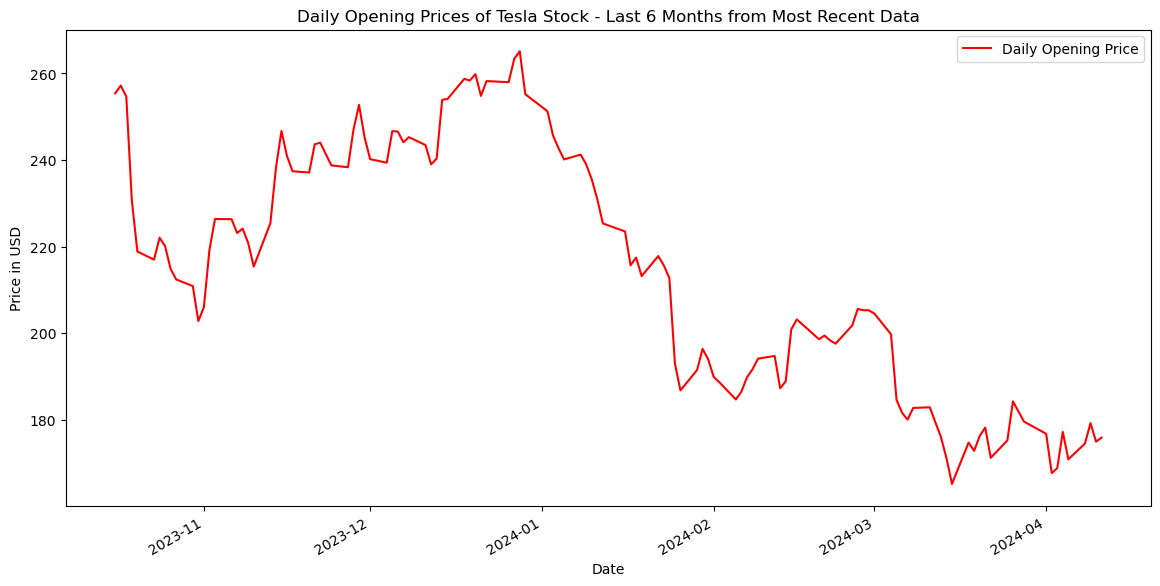

In [13]:
# Get the maximum date from the dataset which represents the most recent stock data
max_date = data['Date'].max()

six_months_prior = max_date - timedelta(days=180)

# Filter the data to get the range between three months prior and the maximum date
six_months_data_full = data[(data['Date'] >= six_months_prior) & (data['Date'] <= max_date)]

# Now let's plot the full six months of daily high and low prices
plt.figure(figsize=(14, 7))
plt.plot(six_months_data_full['Date'], six_months_data_full['High'], color='red', label='Daily Opening Price')
# plt.plot(six_months_data_full['Date'], six_months_data_full['Low'], color='black', label='Daily Low')

# Formatting the plot
plt.title('Daily Opening Prices of Tesla Stock - Last 6 Months from Most Recent Data')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(False)

# Improve date format on x-axis
plt.gcf().autofmt_xdate() # Rotation

# Show the plot
plt.show()

In [14]:
# Both last 3 months show a decreasing trend. 
# Last 6 months show increasing trend until Jan 2024 and then there is a decreasing trend after Jan 2024 with some spikes but generally a decreasing trend.
# Both the graphs show variance, with prices fluctuating between highs and lows over the periods depicted. 
# This can be indicative of various factors influencing the market, such as company performance, economic news, or broader market trends

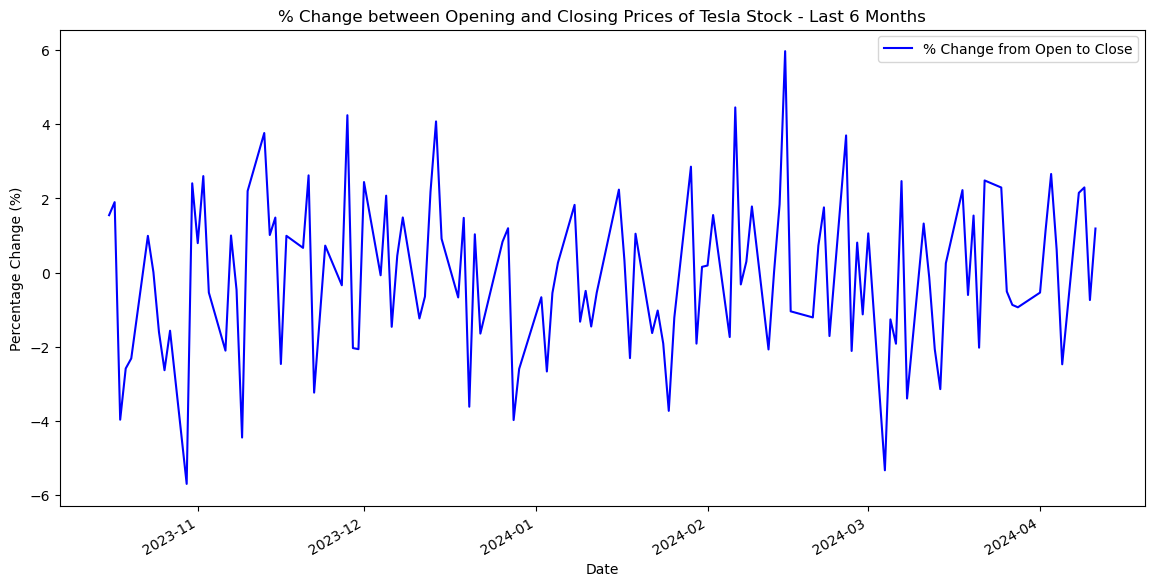

In [15]:
# Filter the data for the last 6 months from the most recent stock data
six_months_prior = max_date - timedelta(days=180)
six_months_data = data[data['Date'] >= six_months_prior]

# Calculate the percentage change between the opening and closing price for the last 6 months
six_months_data['% Change 6 Months'] = ((six_months_data['Close'] - six_months_data['Open']) / six_months_data['Open']) * 100

# Plotting the percentage change for the last 6 months
plt.figure(figsize=(14, 7))
plt.plot(six_months_data['Date'], six_months_data['% Change 6 Months'], color='blue', label='% Change from Open to Close')

# Formatting the plot
plt.title('% Change between Opening and Closing Prices of Tesla Stock - Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(False)

# Set x-axis major locator to month and formatter to DateFormatter

plt.gcf().autofmt_xdate() # Auto format for date rotation and alignment

# Show the plot
plt.show()

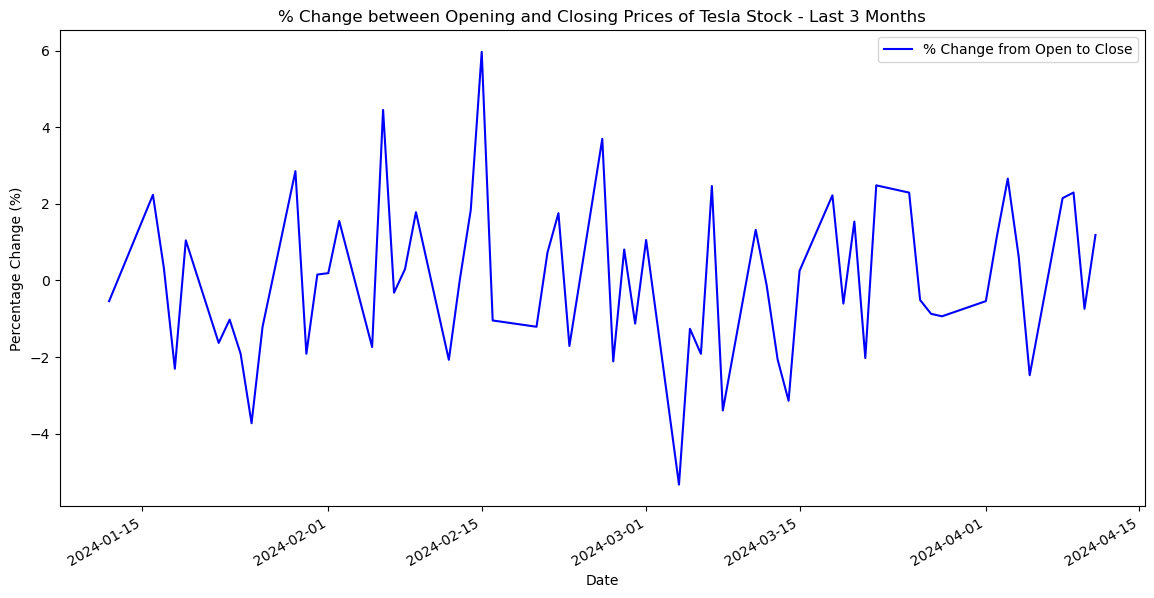

In [16]:
# Filter the data for the last 6 months from the most recent stock data date
three_months_prior = max_date - timedelta(days=90)
six_months_data = data[data['Date'] >= three_months_prior]

# Calculate the percentage change between the opening and closing price for the last 6 months
six_months_data['% Change 3 Months'] = ((six_months_data['Close'] - six_months_data['Open']) / six_months_data['Open']) * 100

# Plotting the percentage change for the last 6 months
plt.figure(figsize=(14, 7))
plt.plot(six_months_data['Date'], six_months_data['% Change 3 Months'], color='blue', label='% Change from Open to Close')

# Formatting the plot
plt.title('% Change between Opening and Closing Prices of Tesla Stock - Last 3 Months')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(False)

# Set x-axis major locator to month and formatter to DateFormatter

plt.gcf().autofmt_xdate() # Auto format for date rotation and alignment

# Show the plot
plt.show()


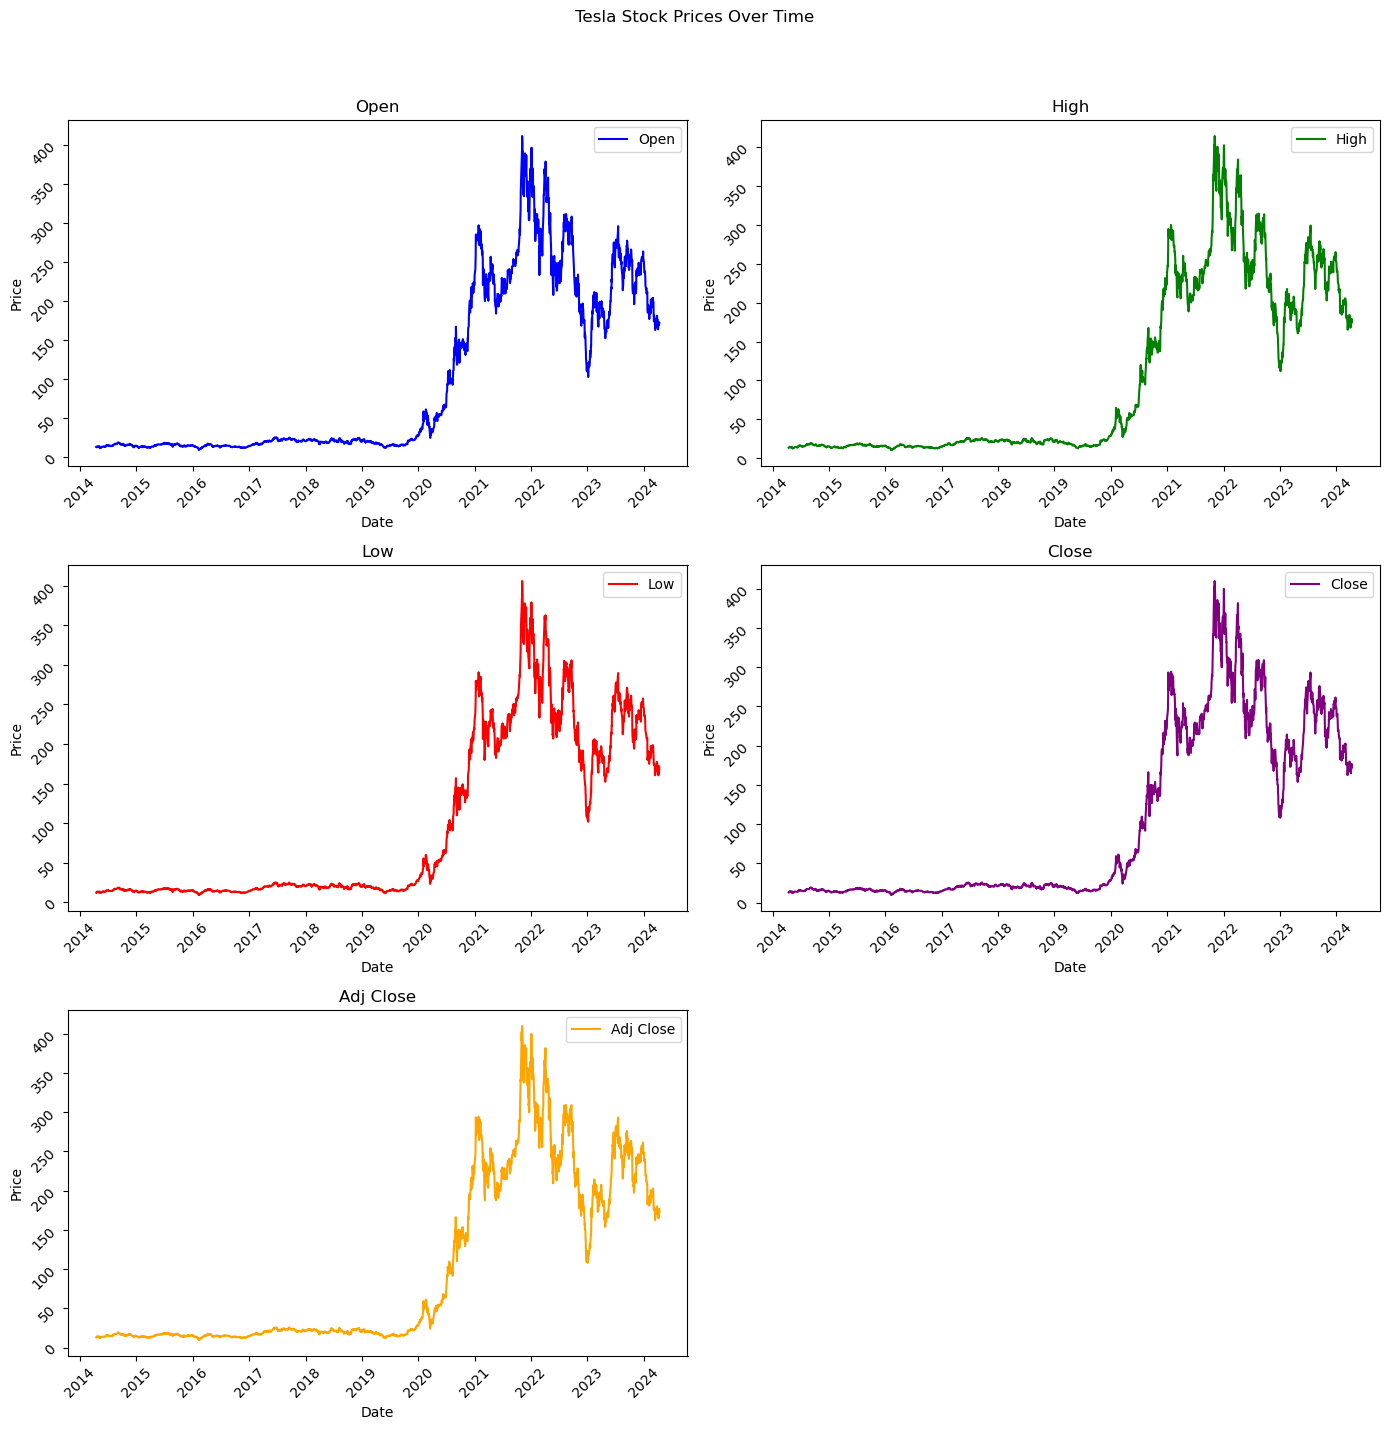

In [17]:
# Assuming 'data' is your DataFrame after loading and converting 'Date'
data['Date'] = pd.to_datetime(data['Date'])

# Set up the matplotlib figure and axes for a 3x2 grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
fig.suptitle('Tesla Stock Prices Over Time')

# Flatten the axes array for easy iteration
axes = axes.flatten()

# To Remove the last subplot (odd number of plots)
fig.delaxes(axes[-1])

# Titles for each subplot
titles = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# Colors for each plot
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot each stock price type in its own subplot
for i, col in enumerate(titles):
    axes[i].plot(data['Date'], data[col], label=col, color=colors[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].legend()
    axes[i].grid(False)
    axes[i].tick_params(labelrotation=45)

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


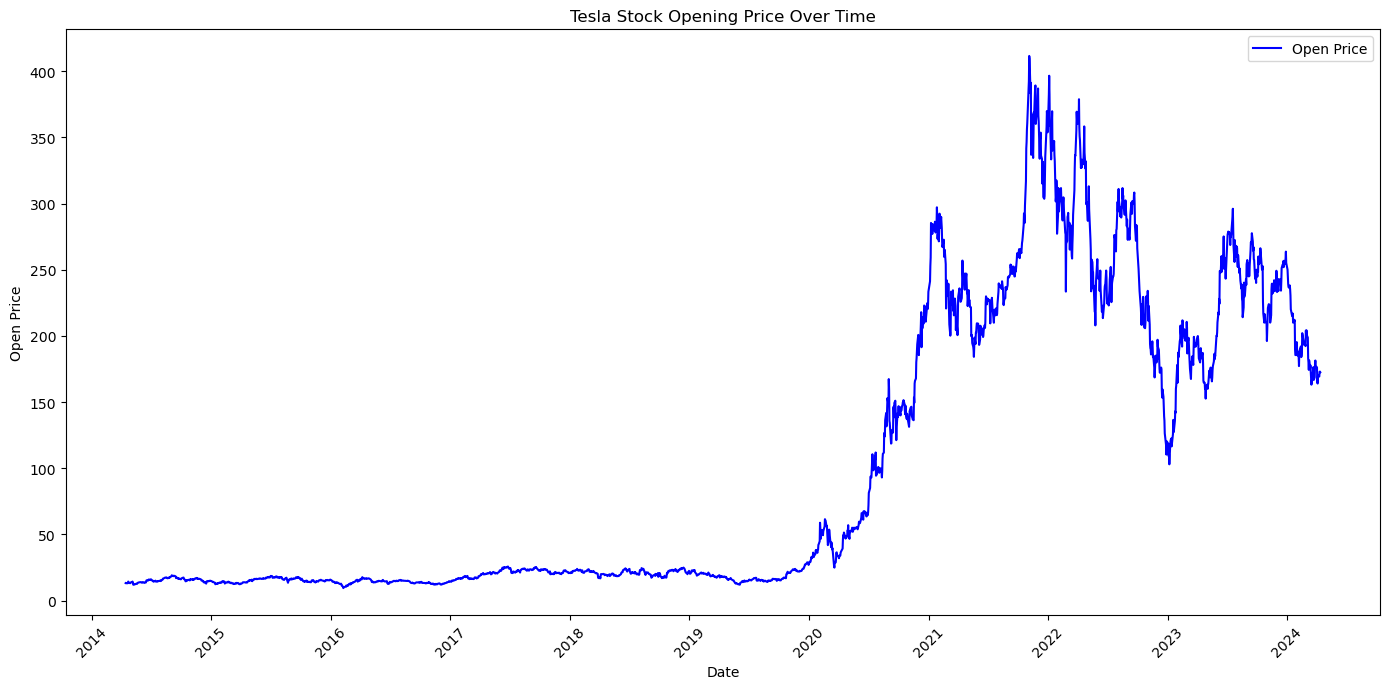

In [18]:
# Convert 'Date' to datetime format for better plotting
data['Date'] = pd.to_datetime(data['Date'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Open'], label='Open Price', color='blue')
plt.title('Tesla Stock Opening Price Over Time')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


<Axes: ylabel='Density'>

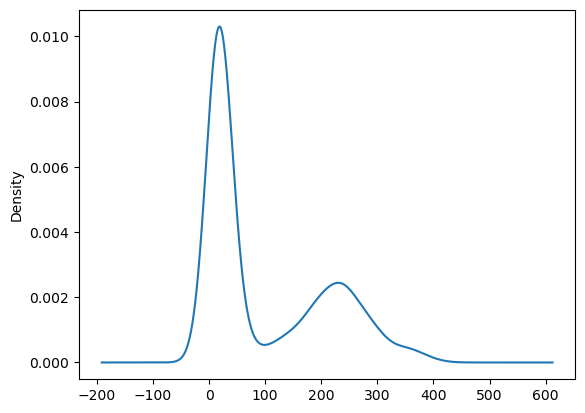

In [19]:
# Distribution of the dataset
data['Open'].plot(kind='kde')

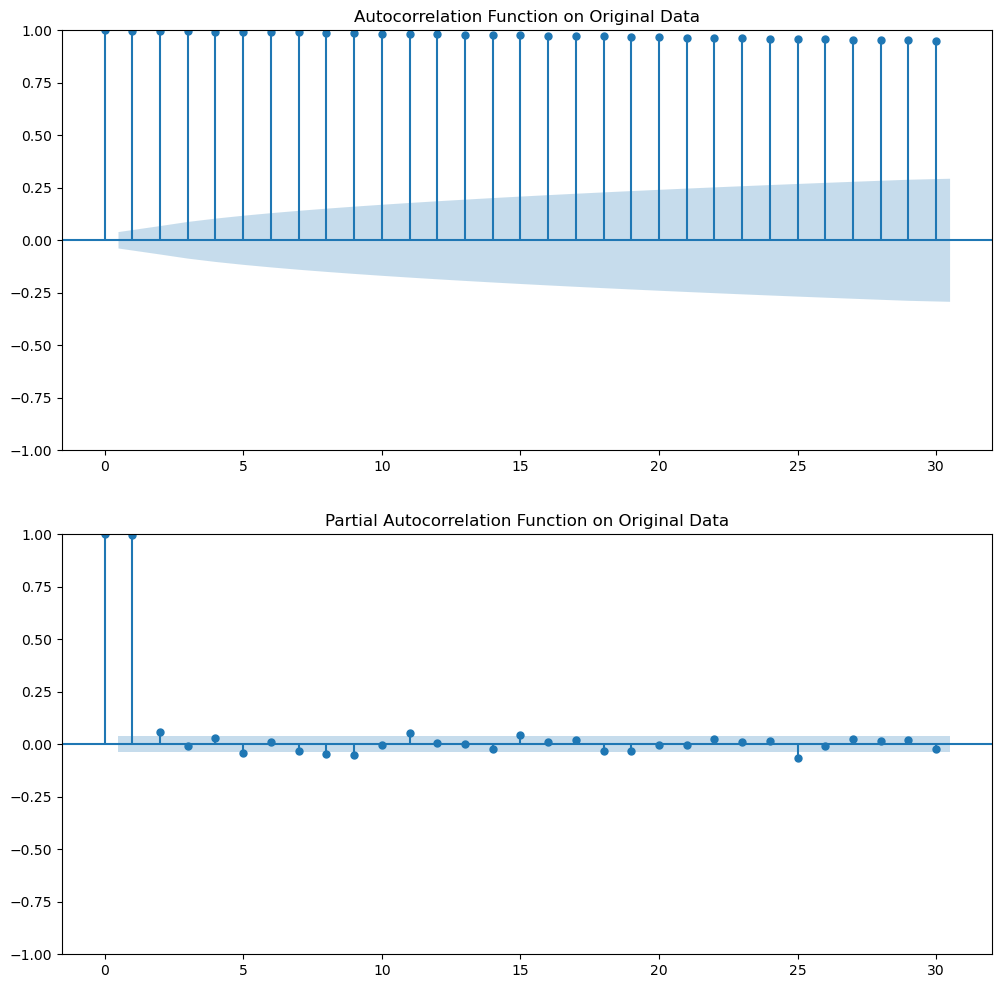

In [20]:
# ACF and PACF plots for the Log Difference of Opening Prices
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the ACF on the first axis
plot_acf(data['Open'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function on Original Data')

# Plot the PACF on the second axis
plot_pacf(data['Open'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function on Original Data')

plt.show()

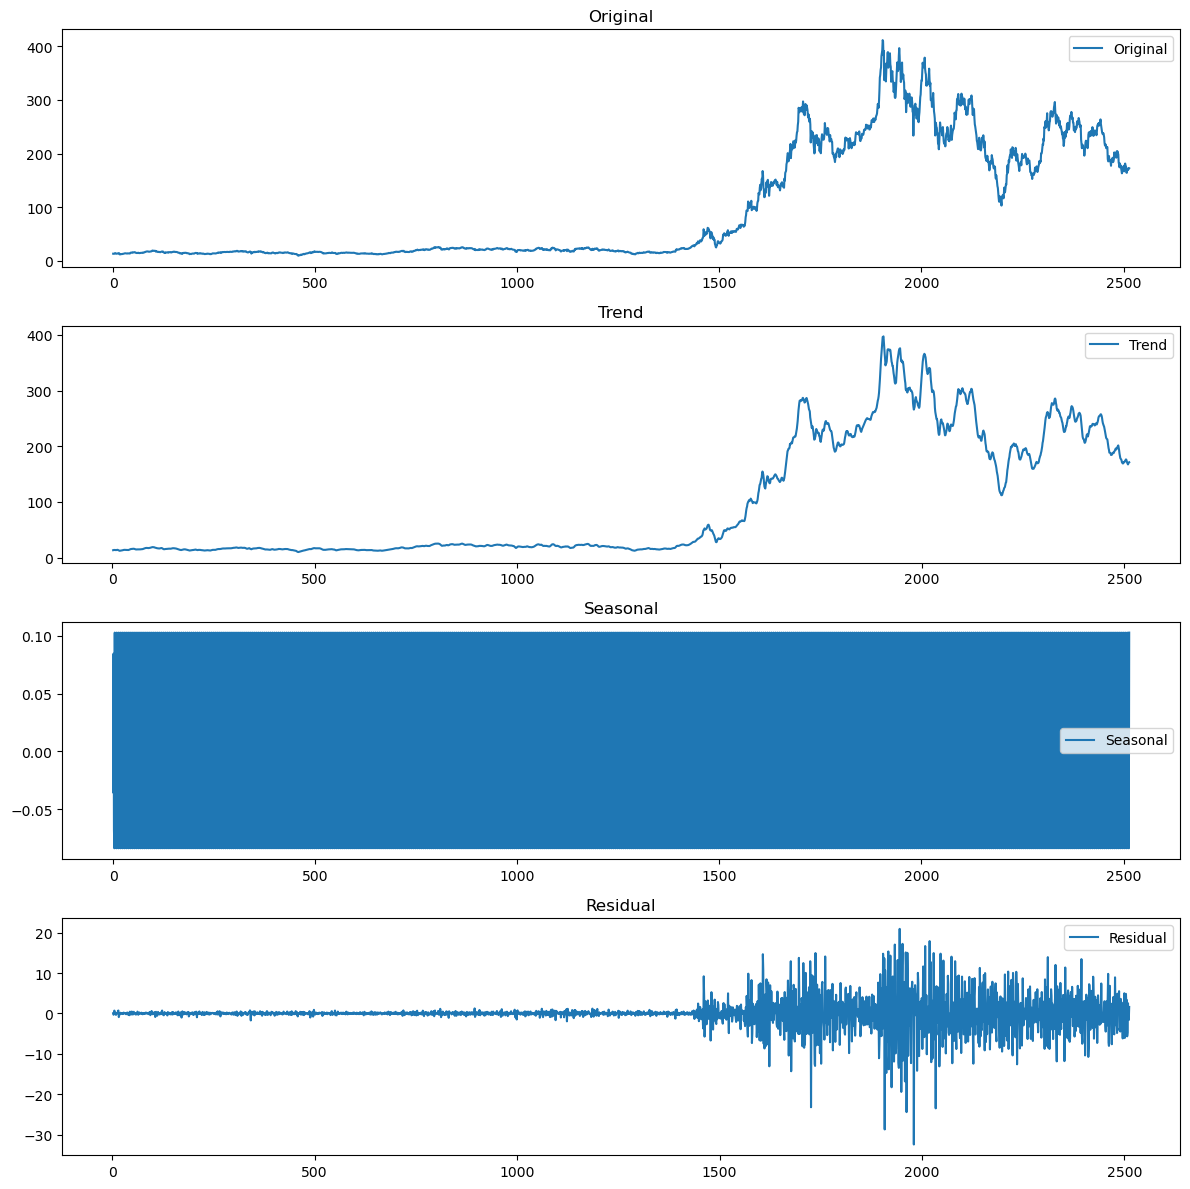

In [21]:
# Decompose the time series data
decomposition = seasonal_decompose(data['Open'], model='additive', period=5)  # Change period based on your data's seasonality

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

ax1.set_title('Original')
ax1.plot(data['Open'], label='Original')
ax1.legend(loc='best')

ax2.set_title('Trend')
ax2.plot(decomposition.trend, label='Trend')
ax2.legend(loc='best')

ax3.set_title('Seasonal')
ax3.plot(decomposition.seasonal, label='Seasonal')
ax3.legend(loc='best')

ax4.set_title('Residual')
ax4.plot(decomposition.resid, label='Residual')
ax4.legend(loc='best')

plt.tight_layout()
plt.show()

In [22]:
adf_result = adfuller(data['Open'])

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output['Critical Value (%s)' % key] = value

adf_output

# With a p-value = 0.569593 from the Augmented Dickey-Fuller (ADF) test, we cannot reject the null hypothesis that there is a unit root present in the series.
# This suggests that the time series is not stationary and would require differencing or other transformations to achieve stationarity.

Test Statistic                   -1.426325
p-value                           0.569593
#Lags Used                       24.000000
Number of Observations Used    2490.000000
Critical Value (1%)              -3.432979
Critical Value (5%)              -2.862701
Critical Value (10%)             -2.567388
dtype: float64

In [23]:
# Applying log difference transformation across the entire dataset
data['Log_Diff_Close'] = np.log(data['Close']).diff()

data['Log_Diff_Open'] = np.log(data['Open']).diff()

data['Log_Diff_High'] = np.log(data['High']).diff()

data['Log_Diff_low'] = np.log(data['Low']).diff()


# Removing the NaN value in the first row that results from the differencing
tesla_stock_log_diff_complete = data.dropna(subset=['Log_Diff_Close'])

print(tesla_stock_log_diff_complete.isnull().sum())

Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Log_Diff_Close    0
Log_Diff_Open     0
Log_Diff_High     0
Log_Diff_low      0
dtype: int64


In [24]:
# Show the head of the dataframe with the new 'Log_Diff' column

tesla_stock_log_diff_complete[['Date', 'Open', 'Log_Diff_Open']].head()


,Date,Open,Log_Diff_Open
1,2014-04-16,13.133333,-0.010553
2,2014-04-17,13.307333,0.013162
3,2014-04-21,13.138667,-0.012756
4,2014-04-22,13.757333,0.046012
5,2014-04-23,14.422000,0.047183


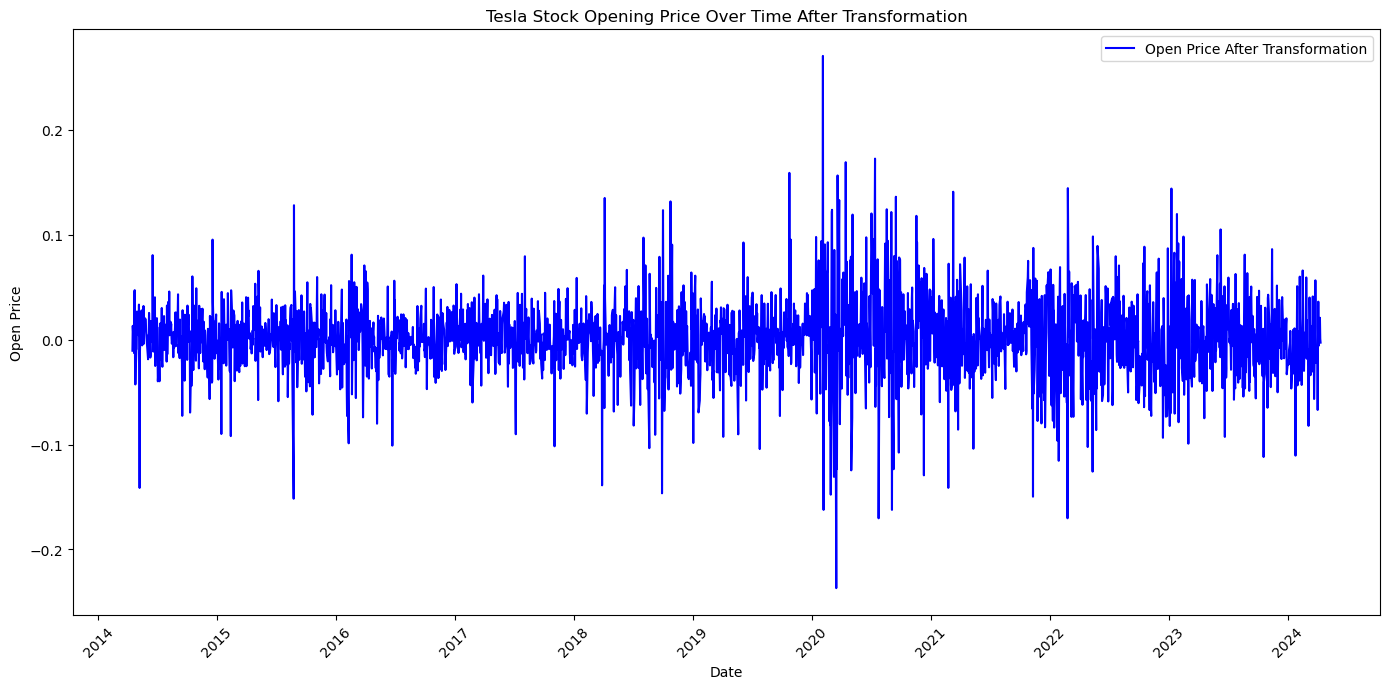

In [25]:
# Convert 'Date' to datetime format for better plotting
tesla_stock_log_diff_complete['Date'] = pd.to_datetime(tesla_stock_log_diff_complete['Date'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(tesla_stock_log_diff_complete['Date'], tesla_stock_log_diff_complete['Log_Diff_Open'], 
         label='Open Price After Transformation', color='blue')
plt.title('Tesla Stock Opening Price Over Time After Transformation')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

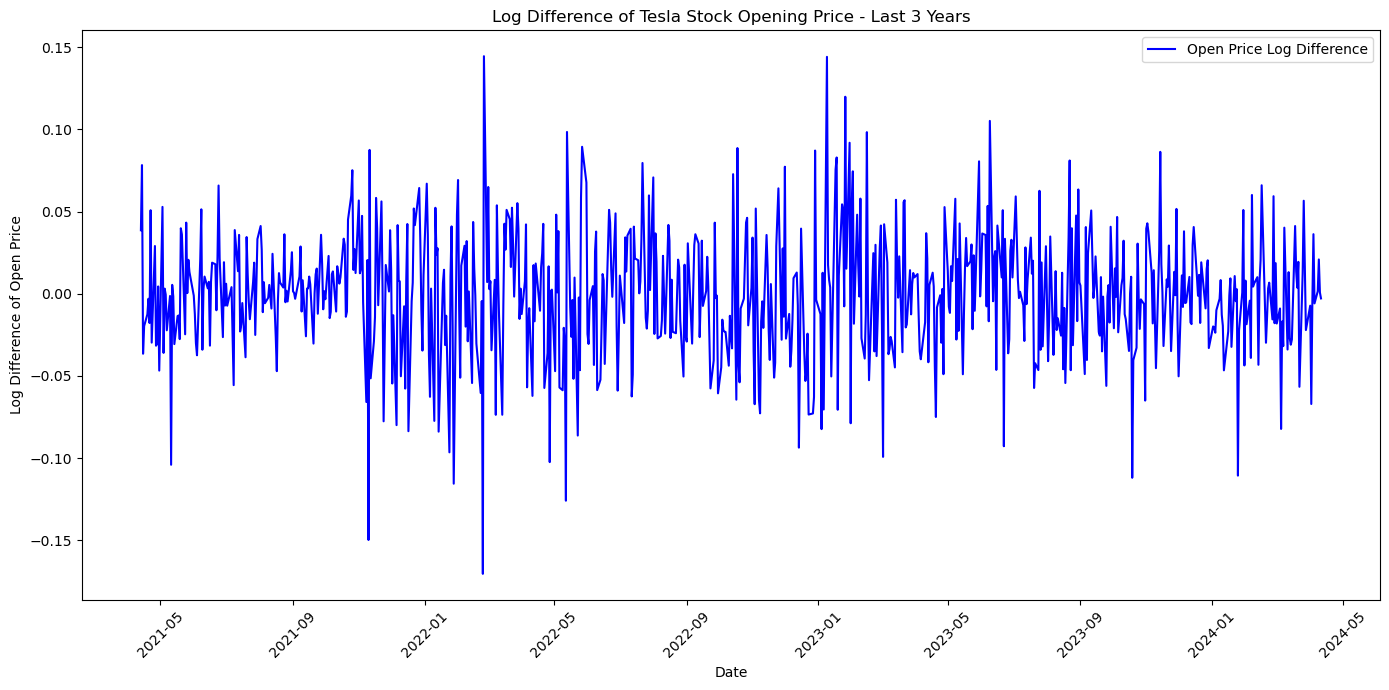

In [26]:
# Adjusting the code to filter for the last three years of data
three_years_ago = tesla_stock_log_diff_complete['Date'].max() - pd.DateOffset(years=3)
three_years_data = tesla_stock_log_diff_complete[tesla_stock_log_diff_complete['Date'] >= three_years_ago]

three_years_data['Log_Open'] = np.log(three_years_data['Open'])
three_years_data['Log_Diff_Open'] = three_years_data['Log_Open'].diff().dropna()

# Plotting the log difference of the Open price for the last three years
plt.figure(figsize=(14, 7))
plt.plot(three_years_data['Date'], three_years_data['Log_Diff_Open'], label='Open Price Log Difference', color='blue')
plt.title('Log Difference of Tesla Stock Opening Price - Last 3 Years')
plt.xlabel('Date')
plt.ylabel('Log Difference of Open Price')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [27]:
adf_result = adfuller(tesla_stock_log_diff_complete['Log_Diff_Open'])

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output['Critical Value (%s)' % key] = value

adf_output

# A p-value of 2.953817e-29 indicates strong evidence against the null hypothesis -> and conclude that the data is stationary.
# The data is likely not affected by trends/seasonality and can be considered stationary for further analysis.


Test Statistic                -1.634762e+01
p-value                        2.953817e-29
#Lags Used                     7.000000e+00
Number of Observations Used    2.506000e+03
Critical Value (1%)           -3.432962e+00
Critical Value (5%)           -2.862694e+00
Critical Value (10%)          -2.567384e+00
dtype: float64

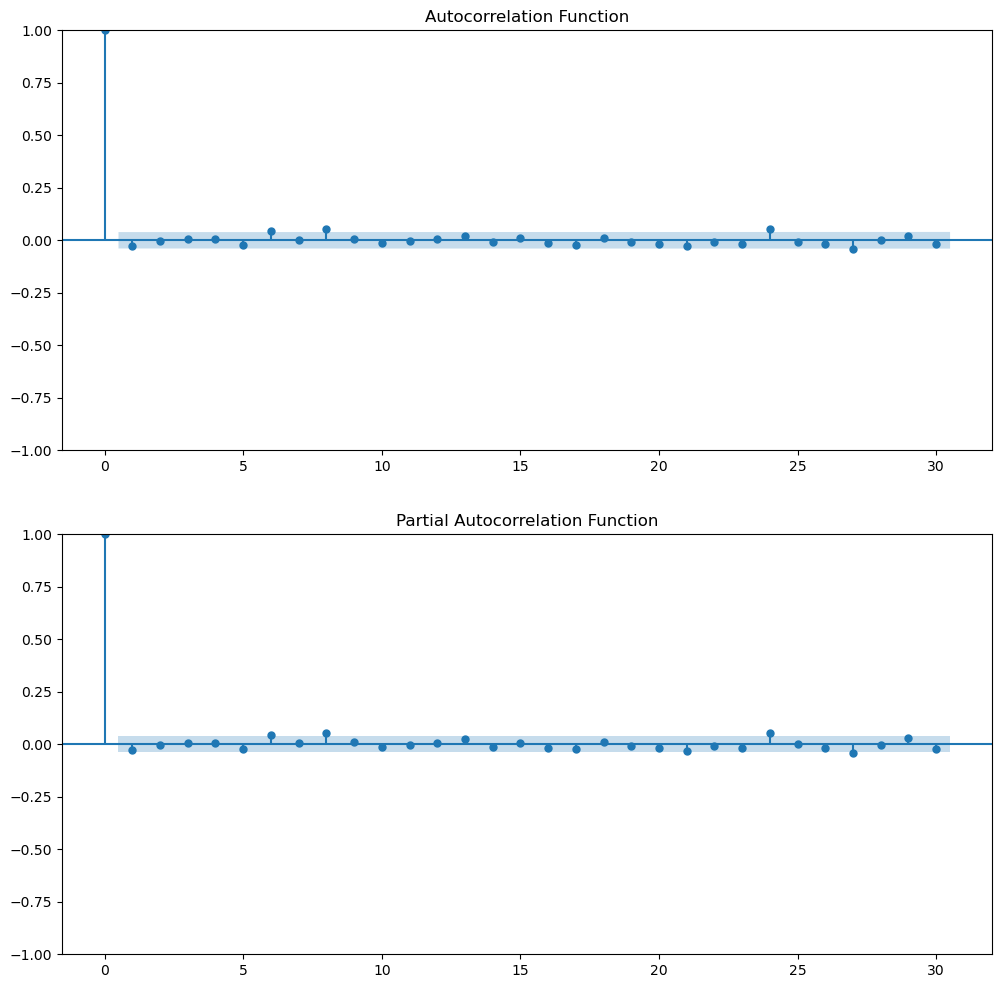

In [28]:
# ACF and PACF plots for the Log Difference of Opening Prices
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the ACF on the first axis
plot_acf(tesla_stock_log_diff_complete['Log_Diff_Open'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function')

# Plot the PACF on the second axis
plot_pacf(tesla_stock_log_diff_complete['Log_Diff_Open'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.show()

In [29]:
# Split the dataset into Train and Test (80 : 20)
unit_rate_series = tesla_stock_log_diff_complete['Log_Diff_Open']

split_point = int(len(unit_rate_series) * 0.8)
train, test = unit_rate_series[0:split_point], unit_rate_series[split_point:]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7628.470, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7627.247, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7627.267, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7625.264, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7630.500, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7629.448, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7629.477, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7627.601, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.539 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2011
Model:                        SARIMAX   Log Likelihood                3817.250
Date:                Sun, 21 Apr 2024   AIC                          -7630.500
Time:                       

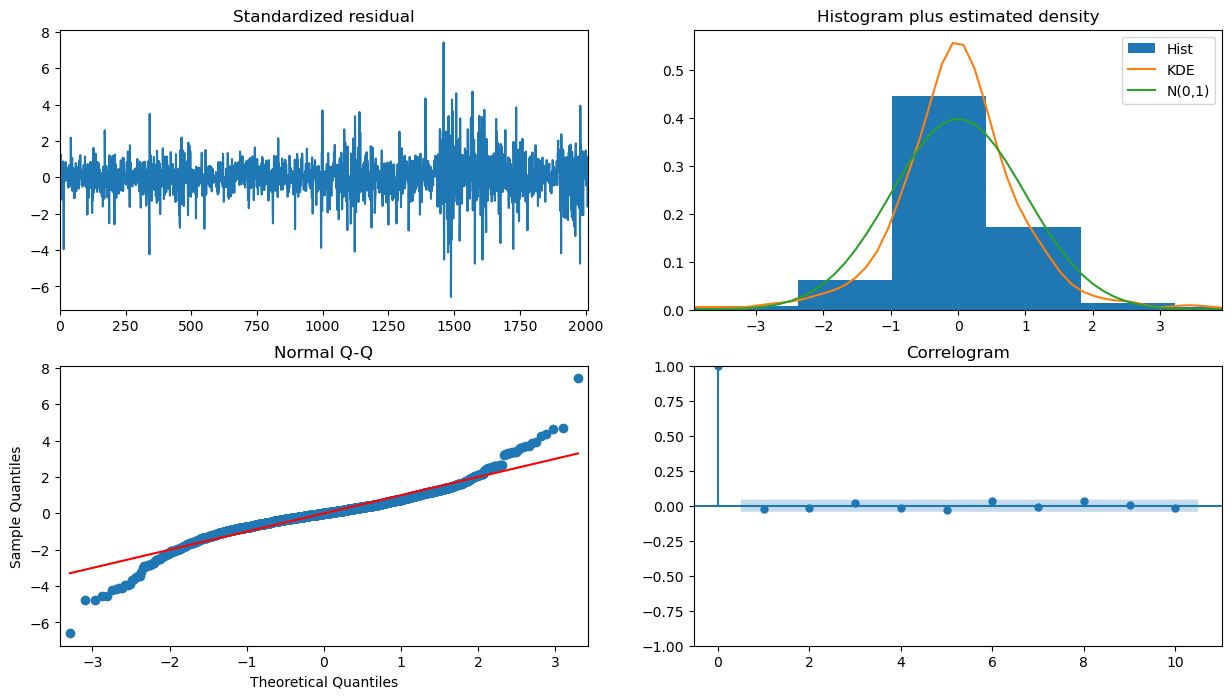

In [30]:
# use pmdarima to automatically select best ARIMA model
auto_model = pm.auto_arima(train, 
                      m=12,               # frequency of series                      
                      seasonal=False,     # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# print model summary
print(auto_model.summary())

auto_model.plot_diagnostics(figsize=(15,8))
plt.show()

                               SARIMAX Results                                
Dep. Variable:          Log_Diff_Open   No. Observations:                 2011
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3817.786
Date:                Sun, 21 Apr 2024   AIC                          -7627.572
Time:                        18:55:35   BIC                          -7605.147
Sample:                             0   HQIC                         -7619.340
                               - 2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.038      0.042    6.21e-05       0.003
ar.L1          0.0871      0.601      0.145      0.885      -1.091       1.265
ma.L1         -0.1088      0.599     -0.182      0.8

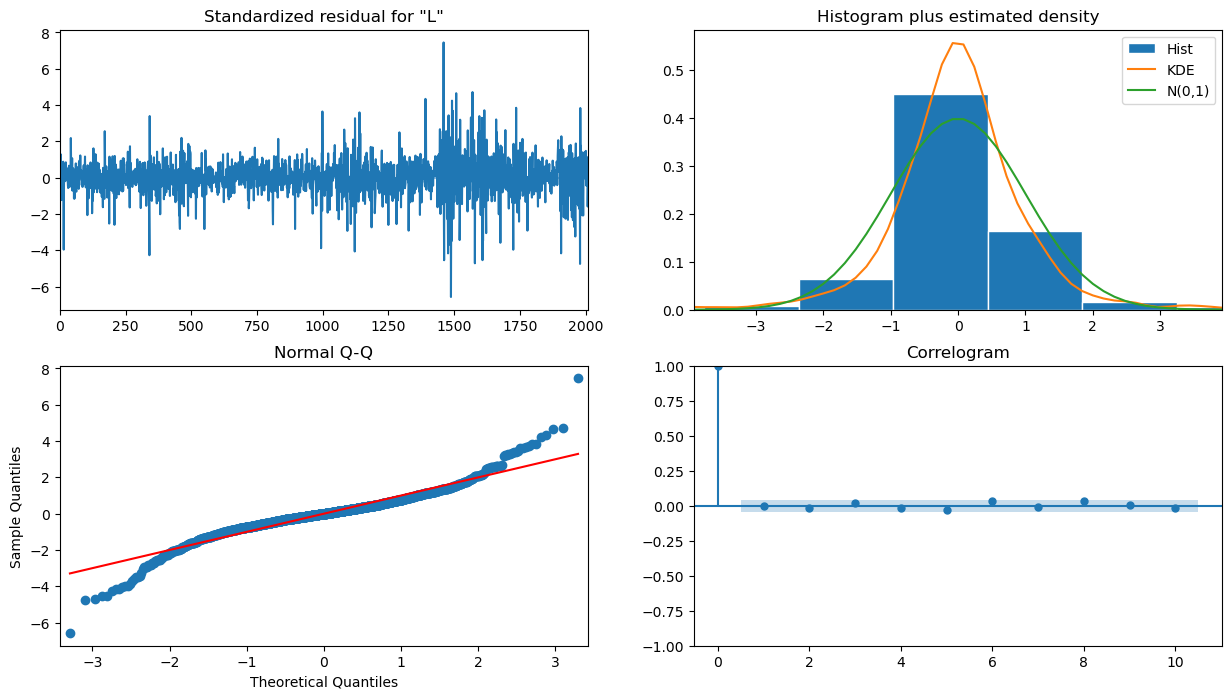

In [31]:
# ARIMA(1,0,1)

model_arima_101 = sm.tsa.ARIMA(train, order=(1,0,1))
results_arima_101 = model_arima_101.fit()

print(results_arima_101.summary())

results_arima_101.plot_diagnostics(figsize=(15,8))
plt.show()

In [32]:
mse_101 = mean_squared_error(train, results_arima_101.fittedvalues)
print(f'Mean Squared Error ARIMA(1,0,1): {mse_101}')

Mean Squared Error ARIMA(1,0,1): 0.0013138672282761096


                               SARIMAX Results                                
Dep. Variable:          Log_Diff_Open   No. Observations:                 2011
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3811.939
Date:                Sun, 21 Apr 2024   AIC                          -7617.877
Time:                        18:55:36   BIC                          -7601.060
Sample:                             0   HQIC                         -7611.704
                               - 2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0226      0.016     -1.442      0.149      -0.053       0.008
ma.L1         -0.9981      0.001   -740.367      0.000      -1.001      -0.995
sigma2         0.0013   2.12e-05     61.954      0.0

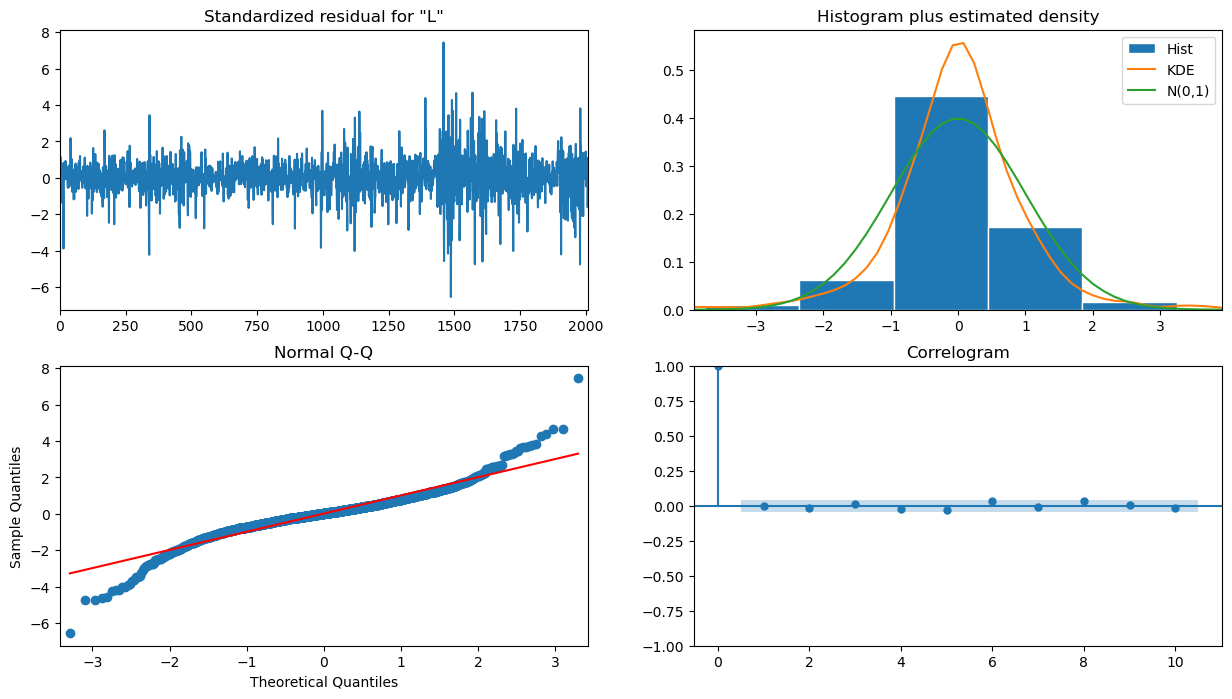

In [33]:
# ARIMA(1,1,1)
model_arima_111 = sm.tsa.ARIMA(train, order=(1,1,1))
results_arima_111 = model_arima_111.fit()

print(results_arima_111.summary())

results_arima_111.plot_diagnostics(figsize=(15,8))
plt.show()

In [34]:
mse_111 = mean_squared_error(train, results_arima_111.fittedvalues)
print(f'Mean Squared Error ARIMA(1,1,1): {mse_111}')

Mean Squared Error ARIMA(1,1,1): 0.0013173165785401223


In [35]:
# arima_orders = [ (1,0,1),  (1,1,1),]
arima_orders = [(1,0,1), (1,1,1)]

results_list = []

for order in arima_orders:
    model = sm.tsa.ARIMA(train, order=order)
    results = model.fit()

    mse = mean_squared_error(train, results.fittedvalues)

    rmse = np.sqrt(mse)

    results_list.append({
        'Model': f'ARIMA{order}',
        'AIC': results.aic,
        'BIC': results.bic,
        'RMSE': rmse
    })

results_df = pd.DataFrame(results_list)

print(results_df.to_string(index=False))


         Model          AIC          BIC     RMSE
ARIMA(1, 0, 1) -7627.572154 -7605.146604 0.036247
ARIMA(1, 1, 1) -7617.877219 -7601.059549 0.036295


In [36]:
# ARIMA(1,0,1) model has the lowest AIC value of -7627.572154
# ARIMA(0,0,0) model has the lowest BIC value of -7605.146604
# Therefore, based on the AIC and BIC values, the ARIMA(1,0,1) model appears to be the best model.

predictions_101 = results_arima_101.get_forecast(steps=60).predicted_mean

In [37]:
# Get the last known open price
last_open_price = data['Open'].iloc[-1]

# Reverse the log differencing for ARIMA(0,0,0) predictions
predicted_log_101 = np.cumsum(predictions_101)
predicted_original_101 = np.exp(predicted_log_101) + last_open_price

In [38]:
model_best_arima = sm.tsa.ARIMA(train, order=(1,0,1))

results_best_arima = model_best_arima.fit()

predictions = results_best_arima.forecast(steps=len(test))

mse = mean_squared_error(train, results_best_arima.fittedvalues)
rmse_best = np.sqrt(mse)
print('Train RMSE: %.3f' % rmse_best)

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

Train RMSE: 0.036
Test RMSE: 0.038


In [39]:
predicted_original_101.head(2)

2011    173.551916
2012    173.553567
Name: predicted_mean, dtype: float64

In [40]:
data.tail(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Diff_Close,Log_Diff_Open,Log_Diff_High,Log_Diff_low
2513,2024-04-10,173.039993,174.929993,170.009995,171.759995,171.759995,84532400,-0.029373,0.000751,-0.024228,-0.011172
2514,2024-04-11,172.550003,175.880005,168.509995,174.600006,174.600006,94367800,0.016400,-0.002836,0.005416,-0.008862


In [41]:
forecast = results_arima_101.forecast(steps=60)

In [42]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

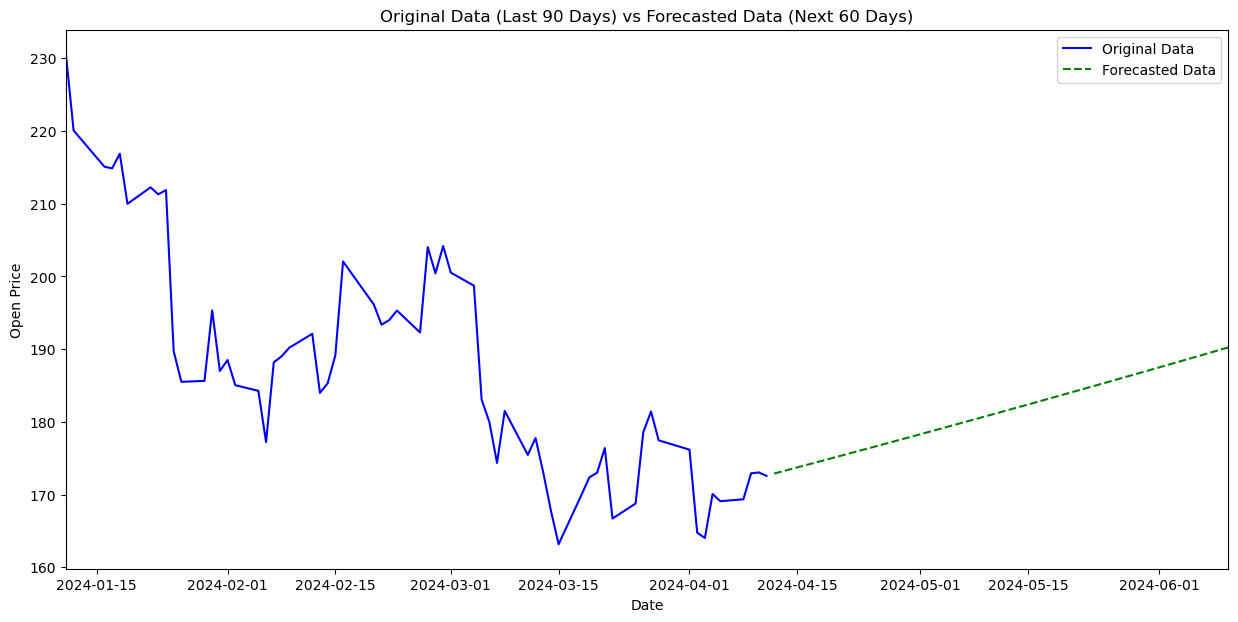

In [43]:
original_series = data['Open']

# Calculate the log of the last value in the series
last_log_value = np.log(original_series.iloc[-1])

# Assuming 'forecast' is a series/array of your forecasted values and 'forecast_index' is their corresponding datetime index
forecast_log = last_log_value + np.cumsum(forecast)
forecast_original_scale = np.exp(forecast_log)

start_date = original_series.index.max() + pd.Timedelta(days=1)
forecast_index = pd.date_range(start=start_date, periods=len(forecast), freq='D')  # 'D' stands for daily frequency.


# Calculate the date three months ago from the last date in the original series
three_months_ago = original_series.index.max() - pd.DateOffset(months=3)

# Filtering the data for the last 3 months
original_series_last_3_months = original_series[three_months_ago:]

plt.figure(figsize=(15, 7))
plt.plot(original_series_last_3_months.index, original_series_last_3_months, label='Original Data', color='blue')
plt.plot(forecast_index, forecast_original_scale, label='Forecasted Data', color='green', linestyle='--')

# Set the x-axis limits to cover from three months ago to the end of forecast data
plt.xlim([three_months_ago, forecast_index.max()])

# Labeling and formatting the plot
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.title('Original Data (Last 90 Days) vs Forecasted Data (Next 60 Days)')
plt.show()

In [44]:
# SARIMA

In [45]:
unit_rate_series = tesla_stock_log_diff_complete['Log_Diff_Open']

split_point = int(len(unit_rate_series) * 0.7)
train1, test1 = unit_rate_series[0:split_point], unit_rate_series[split_point:]

In [46]:
# Seasonal 5
order = (1, 0, 1)
seasonal_order = (1, 1, 1, 5)
model_SARIMA_5 = sm.tsa.SARIMAX(train1, order=order, seasonal_order=seasonal_order)

# Fit the SARIMA model
results_SARIMA5 = model_SARIMA_5.fit()

# Print model summary
print(results_SARIMA5.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75313D+00    |proj g|=  8.51038D+00

At iterate    5    f= -1.82446D+00    |proj g|=  1.84675D-01

At iterate   10    f= -1.83161D+00    |proj g|=  3.02912D+00

At iterate   15    f= -1.83712D+00    |proj g|=  9.92969D-02

At iterate   20    f= -1.83925D+00    |proj g|=  1.65059D+00

At iterate   25    f= -1.86644D+00    |proj g|=  1.86572D+00

At iterate   30    f= -1.88574D+00    |proj g|=  4.59050D-01

At iterate   35    f= -1.89148D+00    |proj g|=  1.40938D-01

At iterate   40    f= -1.89159D+00    |proj g|=  8.14250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [47]:
mse = mean_squared_error(train1, results_SARIMA5.fittedvalues)
rmse_sarima1 = np.sqrt(mse)
rmse_sarima1

0.03622001308327067

In [48]:
# Seasonal 21

order = (1, 0, 1)
seasonal_order = (1, 1, 1, 21)
model_SARIMA_21=sm.tsa.SARIMAX(train1, order=order, seasonal_order=seasonal_order)

# Fit the SARIMA model
model_SARIMA_21 = model_SARIMA_21.fit()

# Print model summary
print(model_SARIMA_21.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73728D+00    |proj g|=  8.25975D+00

At iterate    5    f= -1.80267D+00    |proj g|=  1.12130D-01

At iterate   10    f= -1.80883D+00    |proj g|=  2.89340D+00

At iterate   15    f= -1.81429D+00    |proj g|=  7.45331D-02

At iterate   20    f= -1.81605D+00    |proj g|=  1.43081D+00

At iterate   25    f= -1.84261D+00    |proj g|=  2.36387D+00

At iterate   30    f= -1.85679D+00    |proj g|=  2.84219D-02

At iterate   35    f= -1.85727D+00    |proj g|=  7.92298D-02

At iterate   40    f= -1.85728D+00    |proj g|=  8.13073D-03

At iterate   45    f= -1.85728D+00    |proj g|=  2.82881D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [49]:
mse = mean_squared_error(train1, model_SARIMA_21.fittedvalues)
rmse_sarima21 = np.sqrt(mse)
rmse_sarima21

0.03673638737094495

In [50]:
results_list = []

results_list.append({
        'Model': '[1,0,1,1,1,1,5]',
        'AIC': results_SARIMA5.aic,
        'BIC': results_SARIMA5.bic,
        'RMSE': rmse_sarima1
    })

results_list.append({
        'Model': '[1,0,1,1,1,1,21]',
        'AIC': model_SARIMA_21.aic,
        'BIC': model_SARIMA_21.bic,
        'RMSE': rmse_sarima21
    })

results_df_Seasonal = pd.DataFrame(results_list)

print(results_df_Seasonal.to_string(index=False))

           Model          AIC          BIC     RMSE
 [1,0,1,1,1,1,5] -6644.624327 -6617.276056 0.036220
[1,0,1,1,1,1,21] -6523.911628 -6496.609177 0.036736


In [51]:
forecast_SARIMA = results_SARIMA5.forecast(steps=60)

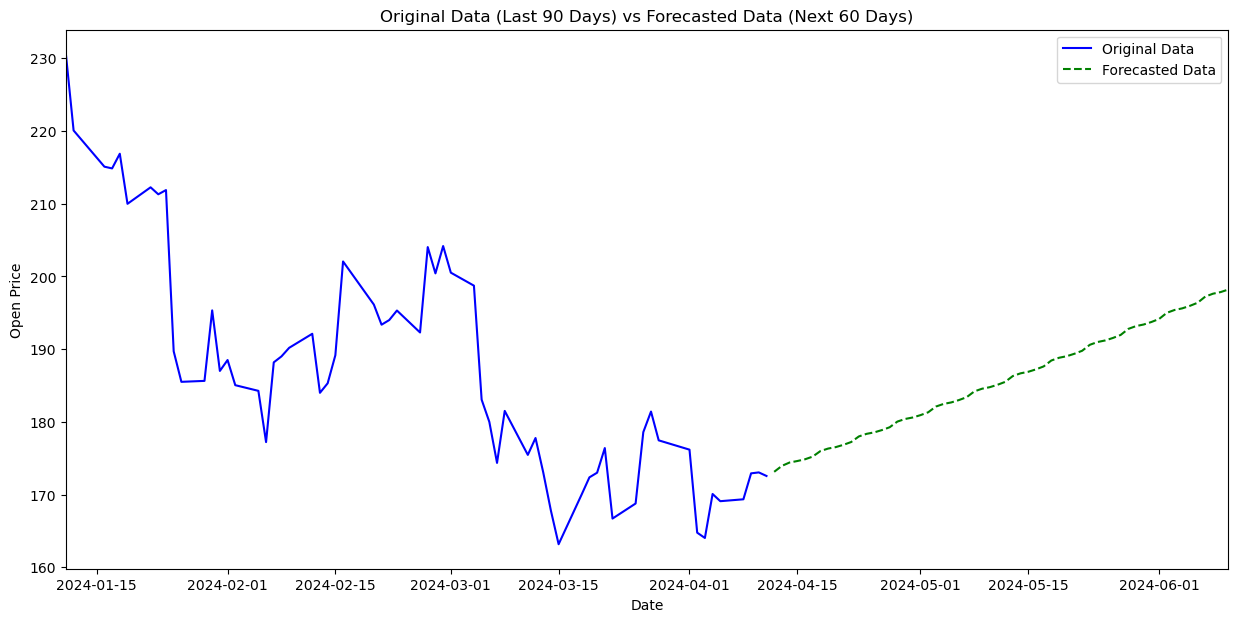

In [52]:
original_series = data['Open']

# Calculate the log of the last value in the series
last_log_value = np.log(original_series.iloc[-1])

# Assuming 'forecast' is a series/array of your forecasted values and 'forecast_index' is their corresponding datetime index
forecast_log = last_log_value + np.cumsum(forecast_SARIMA)
forecast_original_scale = np.exp(forecast_log)

start_date = original_series.index.max() + pd.Timedelta(days=1)
forecast_index = pd.date_range(start=start_date, periods=len(forecast), freq='D')  # 'D' stands for daily frequency.


# Calculate the date three months ago from the last date in the original series
three_months_ago = original_series.index.max() - pd.DateOffset(months=3)

# Filtering the data for the last 3 months
original_series_last_3_months = original_series[three_months_ago:]

plt.figure(figsize=(15, 7))
plt.plot(original_series_last_3_months.index, original_series_last_3_months, label='Original Data', color='blue')
plt.plot(forecast_index, forecast_original_scale, label='Forecasted Data', color='green', linestyle='--')

# Set the x-axis limits to cover from three months ago to the end of forecast data
plt.xlim([three_months_ago, forecast_index.max()])

# Labeling and formatting the plot
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.title('Original Data (Last 90 Days) vs Forecasted Data (Next 60 Days)')
plt.show()

In [53]:
# LSTM

# Long Short term memory networks (LSTM) are a kind of Recurrent neural network (RNN) that remembers information for a long period of time.
# The main aim is to predict the opening price for each day. 
# The model is trained on the stock data from 2014 to 2024 and the model will be used to predict the prices from 2022 to 2024 which amounts to around 75% data for training and 25% data for testing.


In [54]:
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [55]:
openValueDF = pd.DataFrame(data['Open'])

LSTMData = openValueDF.values

LSTMData.shape

(2515, 1)

In [56]:
# Normalization is the process of rescaling the data from the original range so that all the values are between 0 and 1.
# We used Scikit-learn object MinMaxScaler() to normalize the 'Open' column.

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(LSTMData)

In [57]:
# 75% to Train , 25% to Test which gives us 1886 rows in the training set and 689 rows in the testing set.

train_size = int(len(LSTMData)*.75)
test_size = len(LSTMData) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 1886 Test Size : 629


In [58]:
train_data.shape,test_data.shape

((1886, 1), (689, 1))

In [59]:
# Creating a Training set with 60 time-steps and 1 output

# We are going to consider the first 60 days (time-steps) opening price of tesla stock in order to predict the opening price of the 61st day.
# For predicting the opening price of the 62nd day we consider 2–61 days opening price and so on.

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [60]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [61]:
# Reshaping the input
# LSTM expects the input shape to be of the form (Number of observations, TimeSteps, Number of features).
# Hence we need to reshape our data to this form.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [62]:
# The training set has 1826 observations with a timestep value of 60 and a total of 1 feature. 

x_train.shape , y_train.shape

((1826, 60, 1), (1826,))

In [63]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=["mean_absolute_error"])

In [64]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Fitting the LSTM to the Training set
# Training our model for 100 epochs with a batch size of 32.
# We used EarlyStopping callback. It keeps an eye on how well the model is learning from the training data.
# We are monitoring the loss and the goal is to minimize the loss.
# And the wait is for 10 epochs (iterations) to see if the loss is decreasing.
# The assumption is that if there is no improvement in the loss over these 10 epochs, the model might not improve much further and stops the training early. 
# This helps prevent wasting time on training if the model isn't learning anymore.
# When training stops early, the weights (the internal settings) of the model is restored from the epoch where it performed the best.

callbacks = [EarlyStopping(monitor='loss', patience=10 , restore_best_weights=True)]
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32 , callbacks = callbacks )

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0088 - mean_absolute_error: 0.0553
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.0464e-04 - mean_absolute_error: 0.0091
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.6174e-04 - mean_absolute_error: 0.0090
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4707e-04 - mean_absolute_error: 0.0093
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.5039e-04 - mean_absolute_error: 0.0086
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.3224e-04 - mean_absolute_error: 0.0082
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.0554e-04 - mean_absolute_error: 0.0074
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.8143e-04 - mean_absolute_error: 0.0110
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.9140e-04 - mean_absolute_error: 0.0103
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.4695e-04 - mean_absolute_error: 

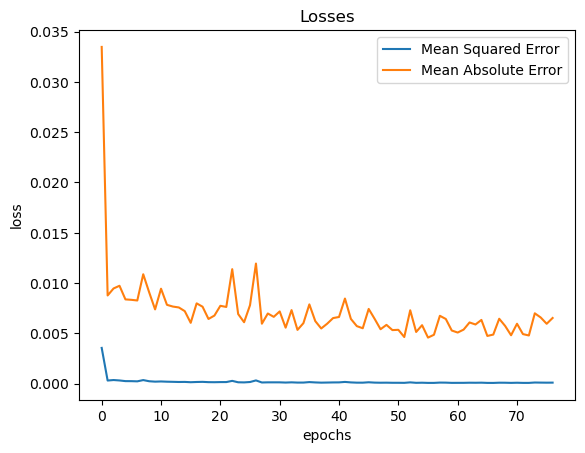

In [66]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [67]:
# Creating a testing set with 60 time-steps and 1 output

x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [68]:
# The test set has 629 observations with a timestep value of 60 and number of features = 1.
x_test.shape, y_test.shape

((629, 60, 1), (629,))

In [69]:
# Making Predictions

# The model is used to make predictions on the the test set. 
# However the predicted values will be normalized and we need to convert it back to the original form in order to plot it on the graph and also to compare with our dataset.
predictions = model.predict(x_test)

# inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(629, 1)

In [70]:
# inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

4.6

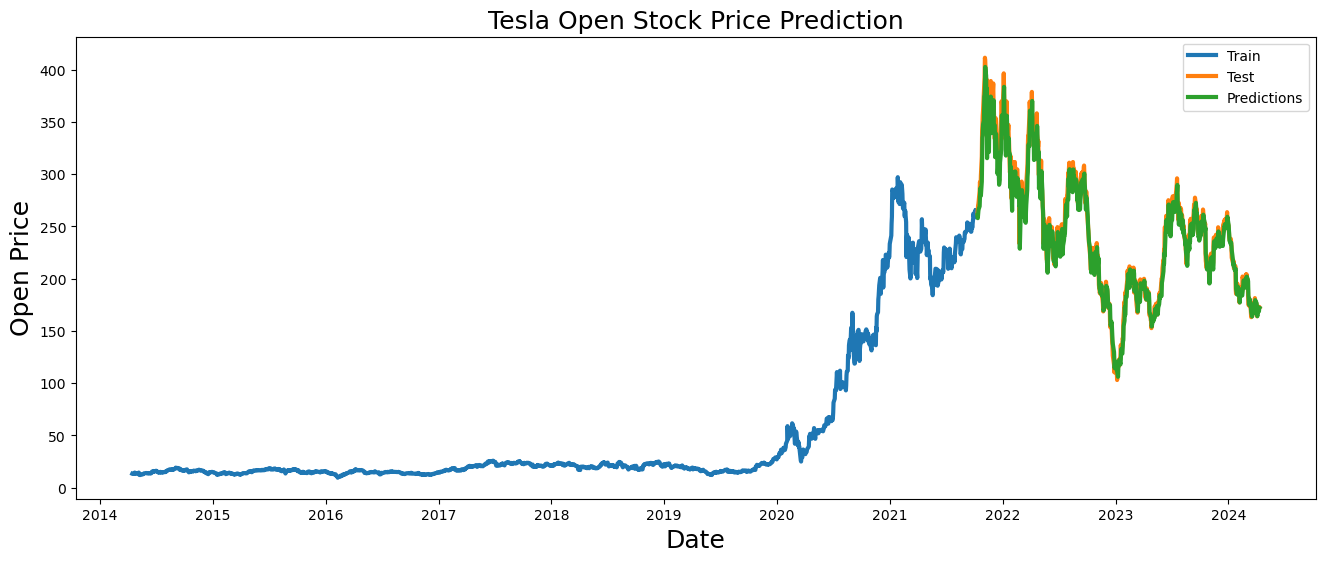

In [71]:
# Model Evaluation
# Plotting the predicted opening price along with the actual opening price (test set)
# The actual data is shown in orange colour and the predicted data is shown in green colour
# Our model seems to be performing well on the test data.

train = openValueDF.iloc[:train_size , 0:1]
test = openValueDF.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Tesla Open Stock Price Prediction' , fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price' ,fontsize=18)
plt.plot(train['Open'],linewidth=3)
plt.plot(test['Open'],linewidth=3)
plt.plot(test["Predictions"],linewidth=3)
plt.legend(['Train','Test','Predictions'])